In [16]:
import EoS_Bits as EOS
import planetary_dictionary as dct
import solve_adams_williamson as aw
import looped_solver

import numpy as np
import math
import random
from matplotlib import pyplot as plt
import csv
import os

r_earth = 6370 * (10 ** 3)

def compute_mass(radii, densities):
    """
    Computes the total mass of a sphere composed of concentric shells.

    Parameters:
    radii (list of float)
    densities (list of float)

    Returns total mass of the sphere
    """
    
    if len(radii) != len(densities):
        raise ValueError("radii and density lists must be same length.")
    
    total_mass = 0.0
    for i in range(len(radii)):
        r_outer = radii[i]
        r_inner = 0 if i == 0 else radii[i - 1]
        volume_shell = (4/3) * math.pi * (r_outer**3 - r_inner**3)
        mass_shell = volume_shell * densities[i]
        total_mass += mass_shell
    
    return total_mass



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

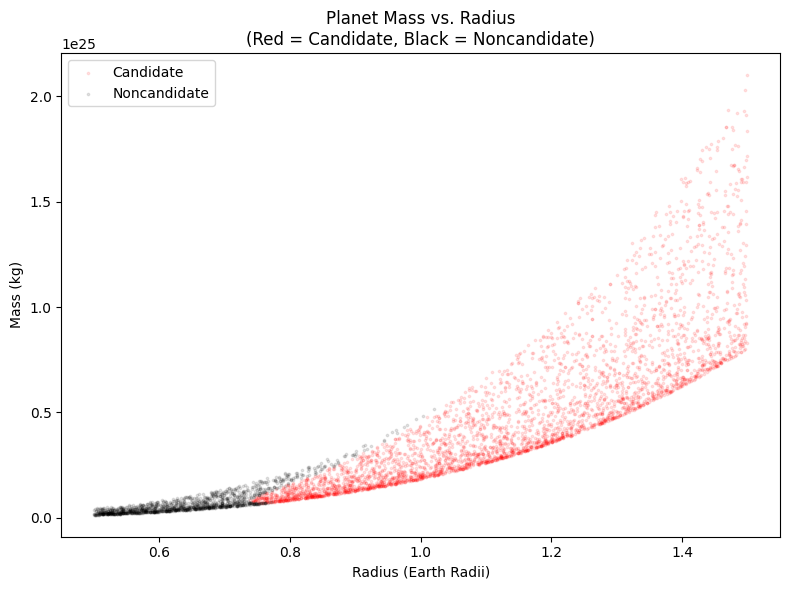

In [24]:
def monte_carlo_plot(number):
    '''Calling this function will output a scatterplot with information about diamond formation candidacy of hypothetical planets along with csv of data.
    Make sure that the names of the scatterplots and csvs already existing in the directory don't interfere or overwrite.
    For visibility, raise the alpha (transparency values) if working with smaller sample sizes.
    '''
    
    base_filename = f"diamond_results_{number}"
    filename = f"{base_filename}.csv"
    counter = 1
    
    while os.path.exists(filename):
        filename = f"{base_filename}_{counter}.csv"
        counter += 1
    
    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        
        writer.writerow(["rand_earth (Earth Radii)", "rand_ice", "rand_iron", "rand_sio2", "planet_mass (kg)", "max_p (Pa)", "diamond_formation"])
        
        for i in range(number):
            rand_earth = random.uniform(0.5, 1.5)
            rand_radius = rand_earth * r_earth
            radii_list = [*range(1, int(rand_radius), int(rand_radius / 1000))]

            rand_ice = random.uniform(0.1, 0.9)
            rand_iron = 0.5 * (1 - rand_ice)
            rand_sio2 = 0.5 * (1 - rand_ice)

            rand_planet = dct.planetary_dictionary(earth_rads=rand_earth, iron_part=rand_iron, sio2_part=rand_sio2)

            density_pressure_lists = looped_solver.Solver(radii_list, rand_planet)

            planet_mass = compute_mass(radii_list, density_pressure_lists[0])

            pressures = density_pressure_lists[1]
            pressures_in_ice = []

            for p in pressures:
                r_index_of_p = pressures.index(p)
                r_for_p = radii_list[r_index_of_p]
                if r_for_p >= list(rand_planet.keys())[1]:
                    pressures_in_ice.append(p)

            max_p = max(pressures_in_ice)

            if max_p >= (10 * (10 ** 9)):
                writer.writerow([rand_earth, rand_ice, rand_iron, rand_sio2, planet_mass, max_p, 'yes'])
            else:
                writer.writerow([rand_earth, rand_ice, rand_iron, rand_sio2, planet_mass, max_p, 'no'])
            print(i)

    yes_diamond_list = []
    no_diamond_list = []

    with open(filename, "r") as f:        
        reader = csv.reader(f)
        next(reader)  
        for row in reader:
            planet_mass = float(row[4])
            max_p = float(row[5])

            if max_p >= (10 * (10 ** 9)):
                yes_diamond_list.append((planet_mass, float(row[0])))  # (planet_mass, rand_earth)
            else:
                no_diamond_list.append((planet_mass, float(row[0])))  # (planet_mass, rand_earth)

    yes_masses, yes_radii = zip(*yes_diamond_list) if yes_diamond_list else ([], [])
    no_masses, no_radii = zip(*no_diamond_list) if no_diamond_list else ([], [])

    plt.figure(figsize=(8, 6))
    plt.scatter(yes_radii, yes_masses, color='red', label='Candidate', alpha=0.1, s=3)
    plt.scatter(no_radii, no_masses, color='black', label='Noncandidate', alpha=0.1, s=3)

    plt.xlabel('Radius (Earth Radii)')
    plt.ylabel('Mass (kg)')
    plt.title('Planet Mass vs. Radius\n(Red = Candidate, Black = Noncandidate)')
    plt.legend()
    plt.tight_layout()
    
    plot_filename = filename.replace(".csv", ".png")
    plt.savefig(plot_filename, dpi=300)
    plt.show()
    
monte_carlo_plot(5000)